In [7]:
import numpy as np
from pathlib import Path
import Visualisation_utils
import matplotlib.pyplot as plt

from active_learning import get_high_variance_cells

LOG_DIR = Path("log/active_learning/AL: testing")


In [8]:
with np.load(LOG_DIR / 'train' / 'val_predictions.npz') as npz_file:
    predict_points = npz_file['points']
    predict_preds = npz_file['preds']
    predict_target = npz_file['target']
    predict_variance = npz_file['variance']  # Variances are normalised to [-1,1]
    predict_point_variance = npz_file['point_variance']
    predict_grid_mask = npz_file['grid_mask']
    predict_features = npz_file['features']
    predict_samples_per_cell = npz_file['samples_per_cell']

In [9]:
cell_centers = np.array([np.mean(predict_points[np.where(predict_grid_mask==i)[0],:3], axis=0) for i in range(len(predict_variance))])

In [10]:
a = np.array([[0,10],[1,11],[2,12]])
print(a.shape)
np.mean(a, axis=0)

(3, 2)


array([ 1., 11.])

In [ ]:
plt.scatter(cell_centers[:,0], cell_centers[:,1], s=3)
plt.xlim(-20,20)
plt.ylim(-10,20)

In [ ]:
variance_ordering_idxs = predict_variance.argsort()[::-1]
num_cells = 10

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster

In [ ]:
kmeans = cluster.KMeans(n_clusters=num_cells, random_state=0).fit(predict_features)

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(cell_centers[:,0], cell_centers[:,1], c=kmeans.labels_, s=10)
plt.xlim(-20,20)
plt.ylim(-10,20)

# add legend to plt
ax.legend(*scatter.legend_elements(), loc="lower left", title="Clusters")
plt.show()

# Finding the optimal K
## Elbow Method 

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

# function returns WSS score for k values from 1 to kmax


def calculate_WSS(points, kmax, kmin=1, ax=None):
    sse = []
    for idx, k in enumerate(range(kmin, kmax+1)):
        kmeans = KMeans(n_clusters=k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        if ax is not None:
            ax[1, idx].scatter(cell_centers[:, 0],
                               cell_centers[:, 1], c=kmeans.labels_, s=10)
            ax[1, idx].set_xlim(-20, 20)
            ax[1, idx].set_ylim(-10, 20)
            ax[1, idx].set_title("k = %d" % k)

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += distance.sqeuclidean(points[i], curr_center)

        sse.append(curr_sse)
    return sse


fig, ax = plt.subplots(2, 10, figsize=(40, 10))
ax[0, 0].set_ylabel('WSS')
ax[0, 0].set_xlabel('Number of clusters')
ax[0, 0].plot(calculate_WSS(predict_features, 10, 1, ax))


## Silhouette Method

In [ ]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sil = []
kmax = 100

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
  kmeans = KMeans(n_clusters = k).fit(predict_features)
  labels = kmeans.labels_
  sil.append(silhouette_score(predict_features, labels, metric = 'euclidean'))

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(sil)

# ReDAL
Score each sample with its uncertainty U

Clusters the samples into K clusters based on their feature embeddings

Sort the regions based on the uncertainty U

For each region, penalise the scores of the remaining regions in that cluster by some factor P

The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).

In [ ]:
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {predict_variance[idx]:.4f} ")

In [ ]:
penalty_factor = 0.9
adjusted_variance = np.copy(predict_variance)
for i, idx in enumerate(variance_ordering_idxs):
    current_cluster = kmeans.labels_[idx]
    for x in range(i+1, len(variance_ordering_idxs)):
        x = variance_ordering_idxs[x]
        if kmeans.labels_[x] == current_cluster:
            adjusted_variance[x] *= penalty_factor

print(f"Old variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
adjusted_variance_ordering_idxs = adjusted_variance.argsort()[::-1]
print(f"New variance_ordering_idxs:\n{adjusted_variance_ordering_idxs[:10]}")
for idx in adjusted_variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {adjusted_variance[idx]:.4f}")

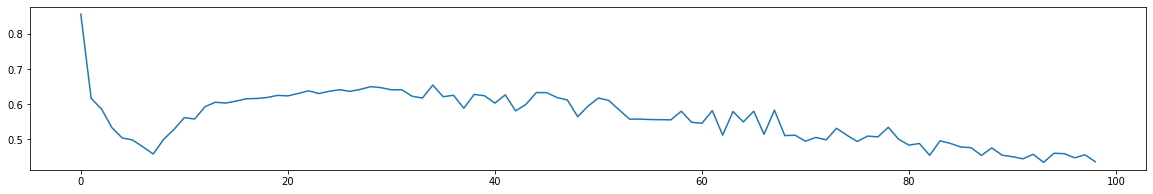

In [122]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm

sil = []
kmax = 100

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax+1)):
  kmeans = KMeans(n_clusters = k).fit(predict_features)
  labels = kmeans.labels_
  sil.append(silhouette_score(predict_features, labels, metric = 'euclidean'))

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(sil)

# ReDAL
Score each sample with its uncertainty U

Clusters the samples into K clusters based on their feature embeddings

Sort the regions based on the uncertainty U

For each region, penalise the scores of the remaining regions in that cluster by some factor P

The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).

In [15]:
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {predict_variance[idx]:.4f} ")

Idx 74, Cluster 2,  variance 0.0438 
Idx 72, Cluster 2,  variance 0.0432 
Idx 68, Cluster 2,  variance 0.0392 
Idx 73, Cluster 2,  variance 0.0386 
Idx 67, Cluster 2,  variance 0.0373 
Idx 75, Cluster 2,  variance 0.0363 
Idx 69, Cluster 2,  variance 0.0361 
Idx 71, Cluster 2,  variance 0.0345 
Idx 65, Cluster 2,  variance 0.0344 
Idx 70, Cluster 2,  variance 0.0340 
Idx 63, Cluster 2,  variance 0.0306 
Idx 59, Cluster 2,  variance 0.0257 
Idx 54, Cluster 2,  variance 0.0250 
Idx 66, Cluster 2,  variance 0.0244 
Idx 61, Cluster 2,  variance 0.0222 
Idx 58, Cluster 2,  variance 0.0219 
Idx 60, Cluster 2,  variance 0.0213 
Idx 57, Cluster 2,  variance 0.0206 
Idx 55, Cluster 2,  variance 0.0193 
Idx 62, Cluster 2,  variance 0.0192 
Idx 52, Cluster 2,  variance 0.0192 
Idx 51, Cluster 2,  variance 0.0182 
Idx 64, Cluster 6,  variance 0.0177 
Idx 96, Cluster 9,  variance 0.0150 
Idx 56, Cluster 2,  variance 0.0136 
Idx 140, Cluster 2,  variance 0.0101 
Idx 50, Cluster 9,  variance 0.0100 


In [16]:
penalty_factor = 0.9
adjusted_variance = np.copy(predict_variance)
for i, idx in enumerate(variance_ordering_idxs):
    current_cluster = kmeans.labels_[idx]
    for x in range(i+1, len(variance_ordering_idxs)):
        x = variance_ordering_idxs[x]
        if kmeans.labels_[x] == current_cluster:
            adjusted_variance[x] *= penalty_factor

print(f"Old variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
adjusted_variance_ordering_idxs = adjusted_variance.argsort()[::-1]
print(f"New variance_ordering_idxs:\n{adjusted_variance_ordering_idxs[:10]}")
for idx in adjusted_variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {adjusted_variance[idx]:.4f}")

Old variance_ordering_idxs:
[74 72 68 73 67 75 69 71 65 70]
New variance_ordering_idxs:
[74 72 68 73 67 75 69 64 71 96]
Idx 74, Cluster 2,  variance 0.0438
Idx 72, Cluster 2,  variance 0.0389
Idx 68, Cluster 2,  variance 0.0317
Idx 73, Cluster 2,  variance 0.0281
Idx 67, Cluster 2,  variance 0.0245
Idx 75, Cluster 2,  variance 0.0215
Idx 69, Cluster 2,  variance 0.0192
Idx 64, Cluster 6,  variance 0.0177
Idx 71, Cluster 2,  variance 0.0165
Idx 96, Cluster 9,  variance 0.0150
Idx 65, Cluster 2,  variance 0.0148
Idx 70, Cluster 2,  variance 0.0132
Idx 63, Cluster 2,  variance 0.0107
Idx 50, Cluster 9,  variance 0.0090
Idx 59, Cluster 2,  variance 0.0081
Idx 141, Cluster 6,  variance 0.0077
Idx 89, Cluster 9,  variance 0.0077
Idx 54, Cluster 2,  variance 0.0071
Idx 53, Cluster 9,  variance 0.0064
Idx 66, Cluster 2,  variance 0.0062
Idx 145, Cluster 9,  variance 0.0057
Idx 61, Cluster 2,  variance 0.0051
Idx 88, Cluster 9,  variance 0.0050
Idx 58, Cluster 2,  variance 0.0045
Idx 90, Cluste